# EP3.1 – Classificação

MAC0417/5768 - Visão e Processamento de Imagens

### Gabriel Bazo
### NUSP: 10277231

[GitHub](https://github.com/gbazo/MAC0417-5768-CV)
[Drive](https://drive.google.com/drive/folders/1gIPJ6pSHb_MJU87CrQYfPtb70KO8Erkf?usp=sharing)

* Os arquivos gerados estão disponíveis no GitHub

## Introdução 
O objetivo desta segunda parte do exercício programa é a classificação dos objetos de interesse. Este processo consiste em extrair features a partir do conjunto de imagens e gerar um modelo para predição das classes das imagens.

## Preparação do ambiente de programação
### Importando as bibliotecas necessárias para a preparação dos dados

In [51]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pickle

In [24]:
file_list = []
class_list = []

# diretório com todas as classes, para o treinamento utilizei as imagens com feret box geradas automaticamente, os 15% processadas manualmente deixei separado para teste no 
# final, ao todo 919 compuseram esse modelo
DATADIR = "/home/gabriel/Documentos/EP CV/4 - auto/6 - feret box/"

# Todas as classes das minhas imagens
CATEGORIES = ["1 - X_CHA", "2- M_TIGELA", "3 - X_CAFE", "4 - FACA", "5 - GARFO",
	      "6 - COLHER", "7 - GARRAFA", "8 - TAÇA", "9 - TIGELA", "10 - PRATO"]

# Comprimento das imagens que irão para a rede neural
IMG_SIZE = 50

# Verificando todas as imagens nas pastas
for category in CATEGORIES :
	path = os.path.join(DATADIR, category)
	for img in os.listdir(path):
		img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

training_data = []

# Criação dos dados para treinamento da rede
def create_training_data():
	for category in CATEGORIES :
		path = os.path.join(DATADIR, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
				training_data.append([new_array, class_num])
			except Exception as e:
				pass

create_training_data()

random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
	X.append(features)
	y.append(label)

# a conversão do x e y para numpy array input do modelo
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y)

# Criação dos arquivos em disco contendo o modelo
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

### Importando as bibliotecas necessárias para a preparação dos dados

A última linha desativa possíveis warnings do Tensorflow

In [11]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

In [25]:
# Recuperando os modelos salvo em disco
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalização dos dados (um pixel varia de 0 a 255)
X = X/255.0

Epoch 1/40
26/26 [==============================] - 1s 31ms/step - loss: 2.3009 - accuracy: 0.1142 - val_loss: 2.2527 - val_accuracy: 0.1429
Epoch 2/40
26/26 [==============================] - 1s 28ms/step - loss: 2.2330 - accuracy: 0.1916 - val_loss: 2.1752 - val_accuracy: 0.1758
Epoch 3/40
26/26 [==============================] - 1s 28ms/step - loss: 2.1226 - accuracy: 0.2294 - val_loss: 2.1194 - val_accuracy: 0.1978
Epoch 4/40
26/26 [==============================] - 1s 27ms/step - loss: 1.9896 - accuracy: 0.2686 - val_loss: 1.9904 - val_accuracy: 0.1978
Epoch 5/40
26/26 [==============================] - 1s 28ms/step - loss: 1.8652 - accuracy: 0.2857 - val_loss: 2.0229 - val_accuracy: 0.1758
Epoch 6/40
26/26 [==============================] - 1s 43ms/step - loss: 1.7503 - accuracy: 0.3088 - val_loss: 1.8963 - val_accuracy: 0.2857
Epoch 7/40
26/26 [==============================] - 1s 50ms/step - loss: 1.5470 - accuracy: 0.3762 - val_loss: 1.7665 - val_accuracy: 0.3297
Epoch 8/40
26

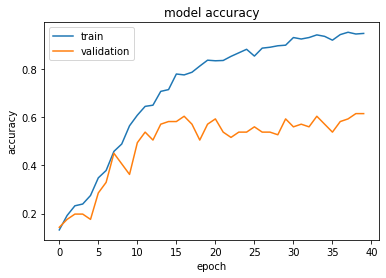

In [27]:
# Iniciando a construção do modelo
model = Sequential()

# Adicionando 3 camadas convolucionais
model.add(Conv2D(32, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# mais duas camadas ocultas, uma com 128 neurônios a segunda com 10 neurônios (número de classes)
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

model.add(Dense(10))
model.add(Activation("relu"))

# Camada de saída com 10 neurônios (número de classes)
model.add(Dense(10))
model.add(Activation("softmax"))

# Compilando o modelo
model.compile(loss="sparse_categorical_crossentropy",
				optimizer="adam",
				metrics=["accuracy"])

# Treino do modelo com 40 interações
# validation_split corresponde à porcentagem de imagens usadas para a fase de validação em comparação com todas as imagens (~92 imagens)
history = model.fit(X, y, batch_size=32, epochs=40, validation_split=0.1)

# Salvando o modelo treinado
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

# Output com as mudanças de precisão durante a fase de treinamento
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### A performance obtida na última interação foi de 95.4% para acurácia no treinamento e 61.5% nas imagens de validação

## Predição de uma imagem

As categorias foram declaradas novamente (apesar de não ser necessário visto que essa variável já existe), a função a seguir ajusta uma nova imagem para ser testada no modelo desenvolvido 

In [40]:
CATEGORIES = ["1 - X_CHA", "2- M_TIGELA", "3 - X_CAFE", "4 - FACA", "5 - GARFO",
	      "6 - COLHER", "7 - GARRAFA", "8 - TAÇA", "9 - TIGELA", "10 - PRATO"]

def prepare(file):
    IMG_SIZE = 50
    img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [61]:
teste = prepare("/home/gabriel/Documentos/EP CV/3 - manual/5 - imagem com feret box/5 - GARFO/66.jpg")

Plot da imagem que está sendo testada no modelo

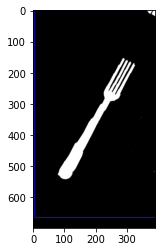

In [57]:
img = cv2.imread("/home/gabriel/Documentos/EP CV/3 - manual/5 - imagem com feret box/5 - GARFO/66.jpg")
plt.imshow(img)

In [67]:
model = tf.keras.models.load_model("CNN.model")
image = teste #your image path
prediction = model.predict([image])
prediction = list(prediction[0])
print(CATEGORIES[prediction.index(max(prediction))])

5 - GARFO


Neste caso o modelo foi capaz de identificar um garfo (acredito ser uma das classes mais difíceis), essa imagem utilizada no teste foi processada manualmente no Gimp e não estava presente no treinamento do modelo, para minha surpresa o mesmo conseguiu acertar.